In [1]:
import sklearn
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import os

from gensim import corpora, models
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from tqdm.notebook import tqdm

In [2]:
questions = pd.read_csv('Dataset/Twitter/train.csv', encoding = "ISO-8859-1", header = None)[[0, 5]].rename(columns = {0: 'class_label', 5: 'text'})
# Mapping the target to 0 and 1
questions['class_label'] = np.where(questions['class_label']==4, 0, 1)
questions.dropna(axis = 0, how = 'any', subset = ['text'], inplace = True)
questions = questions[questions['class_label'] == 1]
questions.head()

,class_label,text
0,1,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1,is upset that he can't update his Facebook by ...
2,1,@Kenichan I dived many times for the ball. Man...
3,1,my whole body feels itchy and like its on fire
4,1,"@nationwideclass no, it's not behaving at all...."


In [3]:
#stoptokens = stoptokens.tokens('english')
import re
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
import preprocessor as p
def custom_standardization(input_data):
    processed_data = p.clean(input_data)
    lowercase_value = processed_data.lower()
    return lowercase_value

def tokenize_and_clean(text):
    text = custom_standardization(text)
    
    #Tokenize
    tweet_tokenizer = nltk.tokenize.TweetTokenizer()
    tokens = tweet_tokenizer.tokenize(text)
   
    # Remove single-character tokens
    tokens = [token for token in tokens if len(token) > 1]

    # Remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]

    # Lowercase all tokens (default_stoptokens are lowercase too)
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords]

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
tqdm.pandas()

questions["tokens"] = questions["text"].progress_apply(tokenize_and_clean)

  0%|          | 0/800000 [00:00<?, ?it/s]

In [5]:
question = questions.copy()
df = questions
questions = questions[questions['class_label'] == 1].sample(n = 2000)

In [6]:
questions['class_label'].value_counts()

1    2000
Name: class_label, dtype: int64

In [7]:
df['class_label'].value_counts()

1    800000
Name: class_label, dtype: int64

In [8]:
from collections import defaultdict
texts = questions['tokens'].to_list()

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

In [9]:
from collections import defaultdict
texts_df = df['tokens'].to_list()

# remove words that appear only once
frequency_df = defaultdict(int)
for text_df in texts_df:
    for token_df in text_df:
        frequency_df[token_df] += 1

texts = [[token_df for token_df in text_df if frequency_df[token_df] > 1]
         for text_df in texts_df]

In [10]:
dictionary = corpora.Dictionary(questions["tokens"])
corpus = [dictionary.doc2bow(doc) for doc in tqdm(questions["tokens"])]

print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Number of unique tokens: 4499
Number of documents: 2000


In [11]:
dictionary_df = corpora.Dictionary(df["tokens"])
corpus_df = [dictionary_df.doc2bow(doc) for doc in tqdm(df["tokens"])]

print(f'Number of unique tokens: {len(dictionary_df)}')
print(f'Number of documents: {len(corpus_df)}')

  0%|          | 0/800000 [00:00<?, ?it/s]

Number of unique tokens: 158794
Number of documents: 800000


In [12]:
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = LdaModel(corpus=tqdm(corpus),
                       id2word=dictionary,
                       num_topics=k,
                       random_state=10,                  
                       passes=3,
                       alpha='asymmetric'
                   )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=questions["tokens"], dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [13]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 1
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Validation sets
num_of_docs = len(corpus)

model_results = {
                 'Topics': [],
                 'Coherence': []
                }

for k in tqdm(topics_range):
    cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k = k)
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)
                    
lda_tuning = pd.DataFrame(model_results)
lda_tuning.to_csv('lda_tuning_results.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: total: 28.1 s
Wall time: 2min 16s


In [23]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.sort_values(by=['Coherence'], ascending=False)

,Topics,Coherence
9,10,0.432457
8,9,0.415960
7,8,0.379302
6,7,0.377491
5,6,0.353970
4,5,0.343317
3,4,0.306628
2,3,0.260189
1,2,0.229458
0,1,0.206059


<AxesSubplot:xlabel='Topics'>

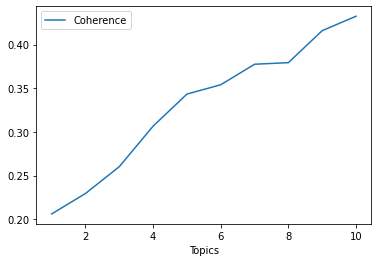

In [15]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line')

In [16]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [17]:
import os
os.cpu_count()

20

In [20]:
%%time

ldamodel = LdaModel(corpus=tqdm(corpus_df),
                       id2word=dictionary_df,
                       num_topics=10,
                       random_state=10,                  
                       passes=5,
                       alpha='asymmetric'
                    # workers=14
                   )

  0%|          | 0/800000 [00:00<?, ?it/s]

CPU times: total: 10min 41s
Wall time: 17min 20s


In [21]:
lda_display = gensimvis.prepare(ldamodel, corpus_df, dictionary_df, sort_topics=True)
pyLDAvis.display(lda_display)

C:\Users\jasme\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
